Предсказание временного ряда при помощи LSTM на примере датасета с объёмами авиаперевозок в США с 1949 по 1960 года

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Conv1D, Flatten
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping

2023-10-02 19:56:36.598147: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 19:56:37.019447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 19:56:37.021249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 19:56:39.036222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.random.set_seed(42)

In [4]:
airline_passengers_data = pd.read_csv('./airline-passengers.csv')
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

In [7]:
year = []
month = []
for time in airline_passengers_data['Month']:
    year.append(time.split('-')[0])
    month.append(time.split('-')[1])
airline_passengers_data['year'] = year
airline_passengers_data['month'] = month
airline_passengers_data.drop('Month', axis= 1 , inplace= True)
airline_passengers_data.head()

,Passengers,year,month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05


In [8]:
X = airline_passengers_data.iloc[:, 1:]
y = airline_passengers_data.iloc[:, :1]

In [9]:
train_size = 100

bias = 5

X_train = X.iloc[:train_size]
X_val = X.iloc[train_size + bias:]
y_train = y.iloc[:train_size]
y_val = y.iloc[train_size + bias:]

In [10]:
scaler = StandardScaler()

X_train[X_train.columns] = scaler.fit_transform(X_train)
X_val[X_val.columns] = scaler.transform(X_val)

X_train.head()

/tmp/ipykernel_5960/4021301488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train)
/tmp/ipykernel_5960/4021301488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[X_val.columns] = scaler.transform(X_val)


,year,month
0,-1.525724,-1.534863
1,-1.525724,-1.247435
2,-1.525724,-0.960008
3,-1.525724,-0.672580
4,-1.525724,-0.385153


In [11]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

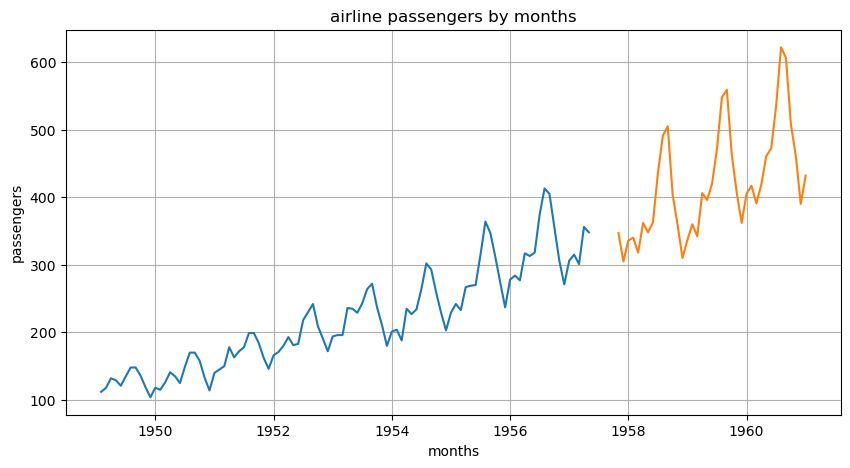

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(X.astype('int').iloc[:train_size]['year'] + (1/12)*X.astype('int').iloc[:train_size]['month'], y_train[:])
plt.plot(X.astype('int').iloc[train_size+bias:]['year'] + (1/12)*X.astype('int').iloc[train_size+bias:]['month'], y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by months')
plt.show()

In [13]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [14]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8, 1)
tf.Tensor([118], shape=(1,), dtype=int64)


#### LSTM

In [15]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4

In [16]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 8s 128ms/step - loss: 51647.1055 - mae: 215.5466 - val_loss: 184103.1406 - val_mae: 421.2077
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 51425.9531 - mae: 215.0625 - val_loss: 183365.5469 - val_mae: 420.3304
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 50700.5039 - mae: 213.5246 - val_loss: 180510.0000 - val_mae: 416.9191
Epoch 4/10
13/13 [==============================] - 0s 20ms/step - loss: 48073.0195 - mae: 207.9109 - val_loss: 169483.0312 - val_mae: 403.4771
Epoch 5/10
13/13 [==============================] - 0s 16ms/step - loss: 39294.0312 - mae: 187.9994 - val_loss: 131497.0469 - val_mae: 353.2269
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 16979.7539 - mae: 122.0890 - val_loss: 44723.4609 - val_mae: 194.1180
Epoch 7/10
13/13 [==============================] - 0s 16ms/step - loss: 2050.4448 - mae: 36.7281 - val_loss: 8083.0547 - val_mae: 65.90

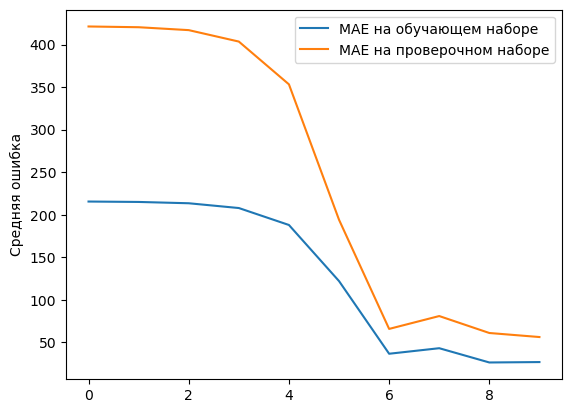

In [17]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [18]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [19]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 27ms/step - loss: 1090.7494 - mae: 25.5214 - val_loss: 6941.9517 - val_mae: 59.2625
Epoch 2/10
13/13 [==============================] - 0s 16ms/step - loss: 1041.2205 - mae: 25.4383 - val_loss: 6485.5464 - val_mae: 57.3245
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 1006.7745 - mae: 24.7064 - val_loss: 6611.8311 - val_mae: 57.7137
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 976.7488 - mae: 24.1672 - val_loss: 6511.1826 - val_mae: 57.2337
Epoch 5/10
13/13 [==============================] - 0s 18ms/step - loss: 947.2183 - mae: 23.8016 - val_loss: 6357.3906 - val_mae: 56.5323
Epoch 6/10
13/13 [==============================] - 0s 18ms/step - loss: 920.4094 - mae: 23.3574 - val_loss: 6260.5425 - val_mae: 56.0358
Epoch 7/10
13/13 [==============================] - 0s 17ms/step - loss: 893.6810 - mae: 22.9871 - val_loss: 6125.0718 - val_mae: 55.3749
Epoch 8/10
13/13 [=============

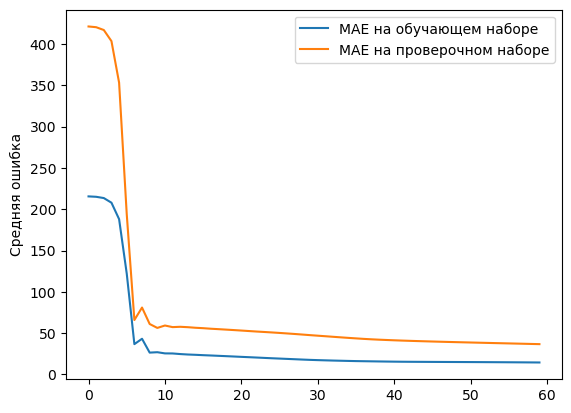

Epoch 1/10
13/13 [==============================] - 0s 17ms/step - loss: 338.5714 - mae: 14.4534 - val_loss: 2468.4497 - val_mae: 36.5112
Epoch 2/10
13/13 [==============================] - 0s 18ms/step - loss: 334.9366 - mae: 14.3807 - val_loss: 2434.6833 - val_mae: 36.2943
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 331.2282 - mae: 14.3049 - val_loss: 2400.8049 - val_mae: 36.1056
Epoch 4/10
13/13 [==============================] - 0s 21ms/step - loss: 327.4439 - mae: 14.2258 - val_loss: 2366.7710 - val_mae: 35.9137
Epoch 5/10
13/13 [==============================] - 0s 18ms/step - loss: 323.5820 - mae: 14.1433 - val_loss: 2332.5452 - val_mae: 35.7138
Epoch 6/10
13/13 [==============================] - 0s 19ms/step - loss: 319.6412 - mae: 14.0574 - val_loss: 2298.0945 - val_mae: 35.5055
Epoch 7/10
13/13 [==============================] - 0s 17ms/step - loss: 315.6205 - mae: 13.9689 - val_loss: 2263.3936 - val_mae: 35.2886
Epoch 8/10
13/13 [================

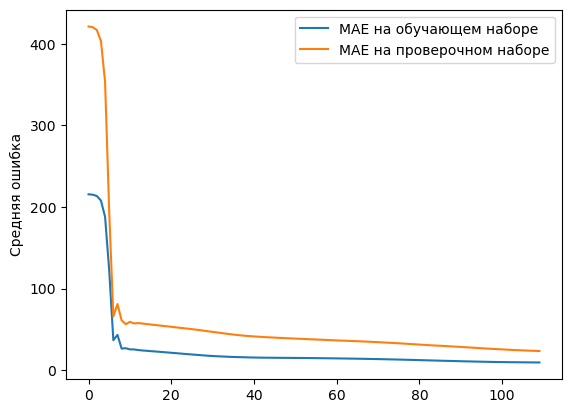

Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 149.8415 - mae: 9.4034 - val_loss: 844.5178 - val_mae: 23.3228
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 148.8487 - mae: 9.3597 - val_loss: 829.6972 - val_mae: 23.1553
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 147.9309 - mae: 9.3252 - val_loss: 816.0233 - val_mae: 23.0009
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 147.1376 - mae: 9.2948 - val_loss: 803.0344 - val_mae: 22.8463
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 146.4207 - mae: 9.2715 - val_loss: 790.9615 - val_mae: 22.6983
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 145.7369 - mae: 9.2514 - val_loss: 780.0193 - val_mae: 22.5752
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 145.1806 - mae: 9.2307 - val_loss: 769.3939 - val_mae: 22.4549
Epoch 8/10
13/13 [==============================

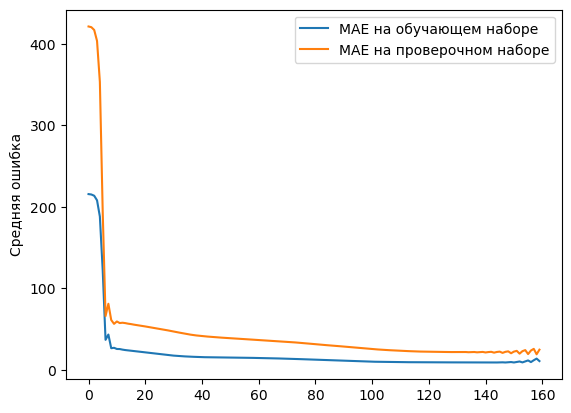

Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 334.2183 - mae: 14.4024 - val_loss: 1066.0300 - val_mae: 28.2037
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 419.5318 - mae: 17.1135 - val_loss: 701.1846 - val_mae: 19.3959
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 319.5961 - mae: 14.8072 - val_loss: 942.2365 - val_mae: 26.2614
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 607.6757 - mae: 19.3028 - val_loss: 1173.9730 - val_mae: 29.6753
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 613.2927 - mae: 20.6259 - val_loss: 801.2318 - val_mae: 20.4203
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 759.3862 - mae: 24.1813 - val_loss: 1345.3494 - val_mae: 32.3982
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 934.5721 - mae: 25.3689 - val_loss: 773.0657 - val_mae: 24.1951
Epoch 1/10
13/13 [====================

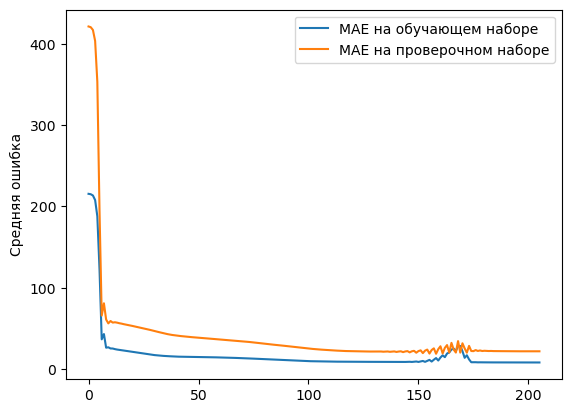

Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 121.0775 - mae: 8.2884 - val_loss: 656.2567 - val_mae: 22.0392
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 121.0508 - mae: 8.2864 - val_loss: 656.6121 - val_mae: 22.0478
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 121.0245 - mae: 8.2843 - val_loss: 657.0463 - val_mae: 22.0574
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 120.9982 - mae: 8.2824 - val_loss: 657.5657 - val_mae: 22.0682
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 120.9715 - mae: 8.2804 - val_loss: 658.1580 - val_mae: 22.0799
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 120.9449 - mae: 8.2785 - val_loss: 658.8174 - val_mae: 22.0925
Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 120.9182 - mae: 8.2766 - val_loss: 659.5465 - val_mae: 22.1060
Epoch 2/10
13/13 [==============================

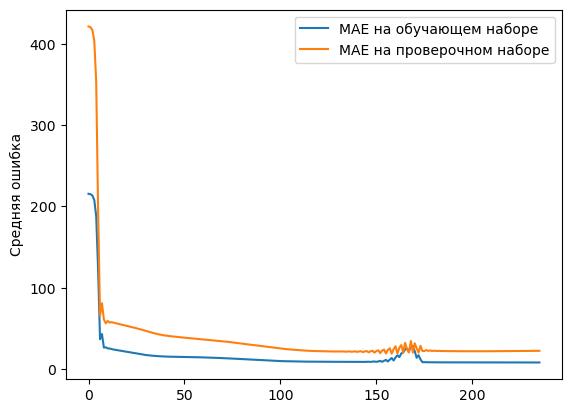

In [20]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [21]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 5ms/step


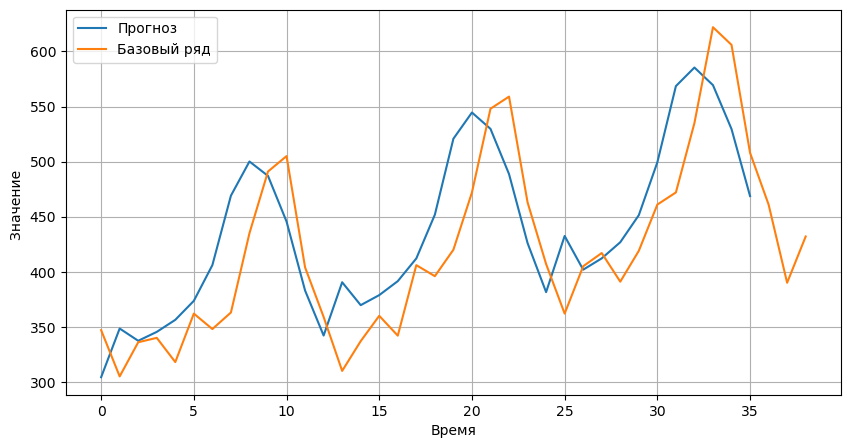

In [31]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(np.array(y_val['Passengers'][start: start+step]), 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

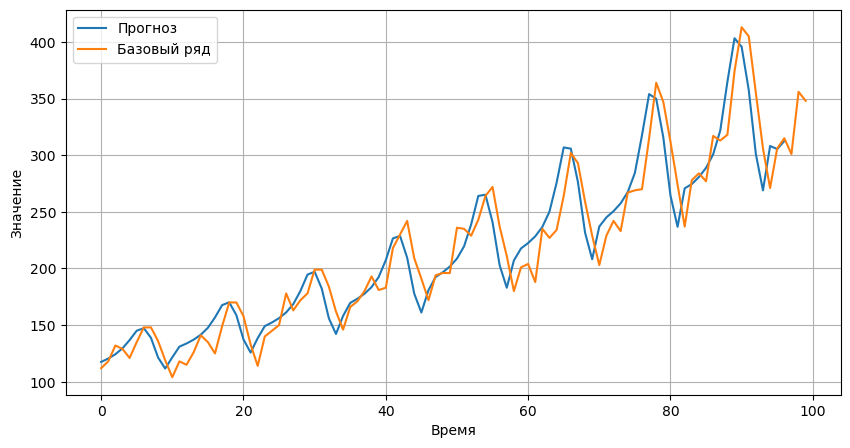

In [35]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(np.array(y_train).flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [36]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

5/5 [==============================] - 0s 5ms/step - loss: 689.0852 - mae: 22.5736
train_loss: 105.97918701171875, train_m: 7.628958702087402
test_loss: 689.085205078125, test_m: 22.573644638061523
